# Neural Network Analysis for Image Classification - Transfer Learning 

This notebook presents an exploration into the domain of image classification using neural networks. The content takes the reader from the foundational steps of data loading and preprocessing to more advanced topics like model training and transfer learning. We also take a moment to reflect on model performance and the implications of our choices.

# Table of Contents:

1. Data Loading
    - Importing Necessary Libraries
    - Loading Data with ImageFolder
    - DataLoader Creation
2. Training the Base Model
    - Defining the CNN Architecture
    - Model Training
    - Model Evaluation
    - Performance Analysis
3. Transfer Learning with EfficientNet_B0
    - DataLoader Adjustments
    - (Subsequent sections related to EfficientNet_B0)
4. Comparing Results
5. Real word scenarios
6. Conclusion


In [30]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

## 1. Load the data using ImageFolder


First we adjust our images to a standard size and format. After that, we organize the images into batches using DataLoaders, to ensure they're primed for neural network input. Then, we can transition to building our foundational model.

In [22]:
data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

In [20]:
# Load the training and test datasets
train_data = datasets.ImageFolder(root='.../Question 2 Data/train', transform=data_transform)
test_data = datasets.ImageFolder(root='.../Question 2 Data/test', transform=data_transform)

In [21]:
# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)


## 2. Train the Base model

Here, we're diving into the core of neural network modeling. By defining our loss function, optimizer, and a simple CNN architecture, we're positioning ourselves to train a model that serves as our benchmark. After the training phase, it's crucial to evaluate the model's performance on our test data, giving us an initial accuracy metric. This foundational model will later be contrasted against a more advanced approach using transfer learning.

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 2 classes
        self.out = nn.Linear(32 * 64 * 64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output


In [35]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=131072, out_features=2, bias=True)
)


In [40]:
num_epochs = 5

# Make sure cnn is in training mode
cnn.train()

errors=[]
      
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        output = cnn(images)               
        curr_error = loss_fn(output, labels)
        errors.append(curr_error.item())
            
        # clear gradients for this training step   
        optimizer.zero_grad()           
            
        # backpropagation, compute gradients 
        curr_error.backward()    

        # apply gradients             
        optimizer.step()                


In [42]:
# Switch the model to evaluation mode
cnn.eval()

correct = 0
total = 0

# No need to track gradients for validation, saves memory and computations
with torch.no_grad():
    for images, labels in test_loader:
        # Run the model on the images
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'The test accuracy of the model -week9- is: {100 * correct / total}%')


The test accuracy of the model -week9- is: 50.0%


The model's poor performance, equivalent to random guessing (50%), is due to its simplicity. It struggles with complex color images of horses and humans. Additionally, training it from scratch without pre-learned features also limits its performance. Hence, it may not generalize well to more complex tasks.

## 3. Perform transfer learning with EfficientNet_B0


Transfer learning is a powerful technique, allowing us to capitalize on pre-trained models. In this section, we turn our attention to the EfficientNet_B0 architecture. Some adjustments to our DataLoaders ensure compatibility with this model. The primary goal is to fine-tune EfficientNet_B0 with our dataset and subsequently evaluate its performance. It's an exciting venture, given the potential of transfer learning to significantly boost classification accuracy.

In [31]:
# create DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

In [15]:
# Load the EfficientNet_B0 model
model = EfficientNet.from_pretrained('efficientnet-b0')


# Modify the final layer to match the binary classification problem
num_ftrs = model._fc.in_features
model._fc = nn.Linear(in_features=model._fc.in_features, out_features=2)

Loaded pretrained weights for efficientnet-b0


In [24]:
num_epochs = 5

model.train()

for epoch in range(num_epochs):
    for batch, (X, y) in enumerate(train_loader):
        y_pred = model(X)

        y = y.long() # convert labels to long type
        curr_error = loss_fn(y_pred, y)

        optimizer.zero_grad()

        curr_error.backward()

        optimizer.step()

    print ('Epoch [{}/{}], Last Batch Loss: {:.4f}' .format(epoch + 1, num_epochs, curr_error.item()))

Epoch [1/5], Last Batch Loss: 0.2288
Epoch [2/5], Last Batch Loss: 0.0105
Epoch [3/5], Last Batch Loss: 0.0001
Epoch [4/5], Last Batch Loss: 0.0023
Epoch [5/5], Last Batch Loss: 0.0000


In [25]:
# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0], data[1]
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 94 %


In [27]:
torch.save(model.state_dict(), "model.pth")

## 4. Comparing Results : 

The EfficientNet_B0 model, utilizing transfer learning, outperformed the simpler CNN significantly. This can be attributed to its pre-training on ImageNet and its architecture, which is more suited to complex image data. On the other hand, the lower performance of the CNN model was expected due to its simplicity and design for grayscale images. 

However, it's important to consider that while EfficientNet_B0 performs significantly better, it's also more complex and computationally expensive than the simple CNN model. 

## 5. Test on real images

In [3]:
image_files = [".../e-horses-test/e_horse1.jpg",".../e-horses-test/e_horse2.jpg",\
               ".../e-test/e_horse3.jpg",".../e-human-test/e_human1.jpg",\
               ".../e-human-test/e_human2.jpg",".../e-human-test/e_human3.jpg",\
               ".../e-test/e_human4.jpg"]

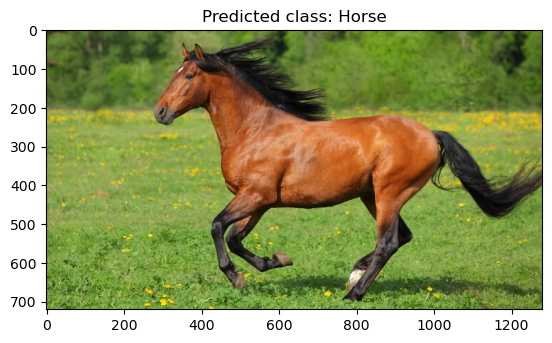

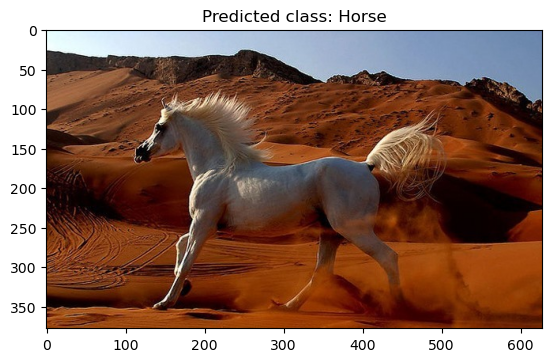

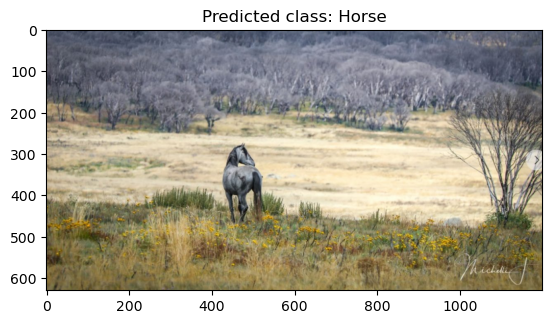

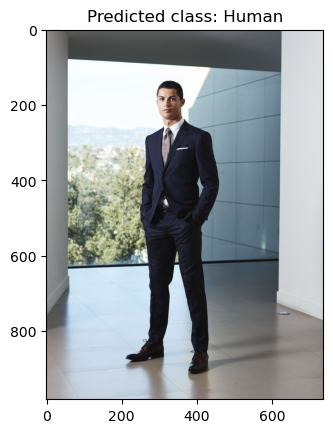

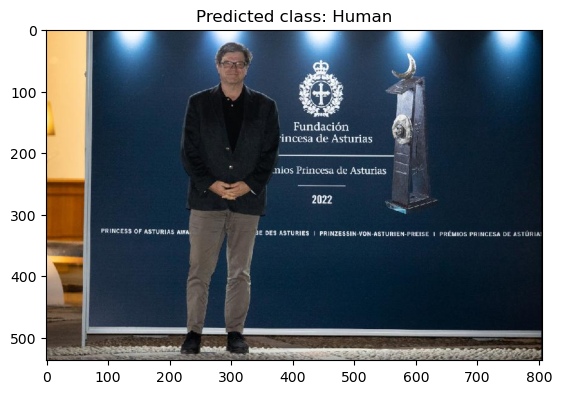

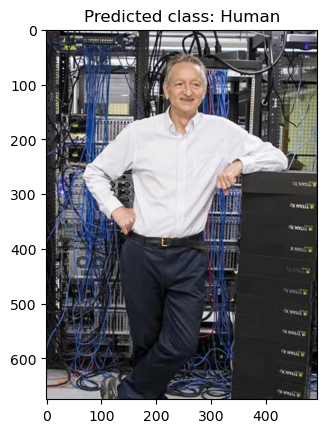

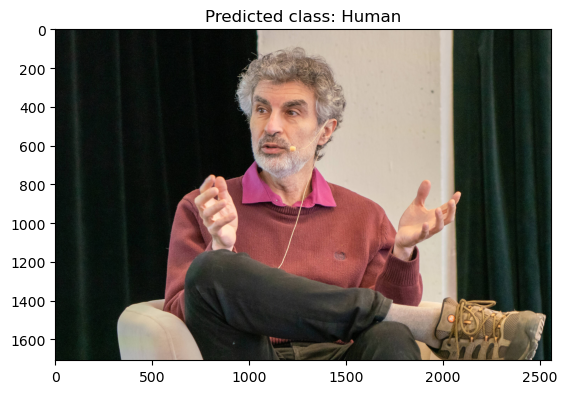

In [28]:
# Prepare the mapping dictionary
idx_to_class = {0: "Horse", 1: "Human"}

# Load your trained model
model.load_state_dict(torch.load("model.pth"))
model.eval()

# For each image, apply the transformations, pass it through the model, and print the prediction
for image_file in image_files:
    image = Image.open(image_file)
    image = data_transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    output = model(image)
    _, prediction = torch.max(output.data, 1)
    predicted_class = idx_to_class[prediction.item()]
    
    # Display the image and its prediction
    img=mpimg.imread(image_file)
    imgplot = plt.imshow(img)
    plt.title(f'Predicted class: {predicted_class}')
    plt.show()


The model was able to correctly classify all of the new images of horses and humans. suggesting that the model has generalized well from the training data and is able to correctly classify new images that it has not seen before.

The chosen images to test the model were somewhat different from the training images. The training images all had a white background and depicted the subject (either a horse or a human) in a clean and isolated manner. On the other hand, the images I used to test the model were "real" in the sense that they depicted horses and humans in natural environments with varying backgrounds, clothing and angles.

Despite these differences, the model was still able to classify the images correctly. However, this doesn't guarantee that it will always perform well on real images, especially if the images contain more complex backgrounds or other objects that were not present in the training data. The model might also struggle to correctly classify images where the subject (the horse or human) is only a small part of the image, as it has been trained on images where the subject is the main focus.

So, although the results of this small test are promising, further testing with a larger and more varied set of images would be needed to truly assess the  performance and generalization of the model.

## 6. Real world scenarios 

Autonomous Vehicles: being able to detect humans and horses  is very important. For instance, if a self-driving car can correctly identify a horse in the field, it may anticipate a potential risk (like the horse running onto the road) and take preventive measures. Similarly, recognizing humans can aid in pedestrian detection.

Surveillance and Security Systems: Identifying humans in video footage or images. For instance, detecting a human trespassing in an off-limits area or detecting unusual activity during off-hours could trigger an alarm. In contrast, for locations such as farms or ranches, detecting horses could be useful to ensure they are safe, monitor their movements, and even alert the authorities or owners if they escape their designated areas.


## 7. Conclusion

In this notebook, we dived into the world of image classification, working with a dataset of horses and humans. We explored both a basic neural network model and a more advanced approach using transfer learning with EfficientNet_B0. By comparing their performances, we gained insights into the strengths and challenges of each method. The tests on real-world-like scenarios further enriched our understanding. Overall, this exercise showcased the potential of neural networks in image classification and provided valuable learnings for future projects.